# Detecting Traffic Shaping

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Files to Download

#### PCAPs
pcapA - https://drive.google.com/file/d/1kge-ZLACRjTAFfX2RWiL--eSt0-CXfwj/view?usp=drive_link  
pcapB - https://drive.google.com/file/d/1fwDyURIWEIMRPP-ZfPFTMAFgorNUzIi0/view?usp=drive_link  
pcapC - https://drive.google.com/file/d/1PgnlIYSwTc5GS48gtkG-tFFElsN0MXYE/view?usp=drive_link  
pcapD - https://drive.google.com/file/d/1PmkA_R8i3jzowObkcywpjGe3wiLmjEJq/view?usp=drive_link  

#### CSVs
pcapA.csv - https://drive.google.com/file/d/1tUAicJcWACDTaEmZulN_lQugNKAmFrkR/view?usp=drive_link  
pcapB.csv - https://drive.google.com/file/d/1AT9hL8wygR3FY3quyUv7OwZZemEahigX/view?usp=drive_link  
pcapC.csv - https://drive.google.com/file/d/1No2zwKpGvoqQOYuvvurHrFpniEFT8J2t/view?usp=drive_link  
pcapD.csv - https://drive.google.com/file/d/1yUPkyrXDKbAizlJDubrkstoVMixRz03O/view?usp=drive_link  

## Traffic Shaping Review

Bandwidth traffic shaping focuses on controlling the flow and volume of data traffic on a network.

This process is essential for preventing network congestion, maintaining consistent network performance, and ensuring that certain applications receive the bandwidth they need.

By controlling the data flow, traffic shaping prevents network links from becoming overloaded, reducing the chances of congestion and packet loss.  

Traffic shaping helps in maintaining the quality of service by prioritizing certain types of traffic, such as VoIP (Voice over IP) or streaming video, which require consistent and reliable bandwidth.  

Traffic shaping ensures that available bandwidth is used efficiently, avoiding scenarios where some applications consume excessive bandwidth at the expense of others.

#### Why can traffic shaping be bad?

Traffic shaping can limit the available bandwidth for certain applications or users

Traffic shaping policies may inadvertently prioritize certain types of traffic over others, potentially leading to fairness issues

While traffic shaping can help manage bandwidth for bulk transfers, it might negatively impact real-time applications that require consistent low-latency and jitter-free performance

### Token Buckets

The token bucket is a simple and effective algorithm used to control the amount of data that a network can send over a given period. It is widely used in traffic shaping to smooth out bursts of traffic and ensure that data transmission adheres to a specified rate.  

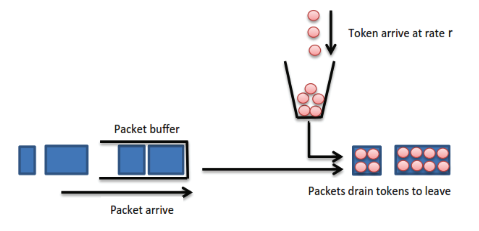

image from: https://jacta.utem.edu.my/jacta/article/view/5205

#### What are the downsides of token buckets?

## Load up the PCAP in wireshark

### In this packet capture we have data transfer over a single TCP flow. 
Identify the relevant IP addresses / ports for this call

## Initialize Spark (or use Pandas)

In [2]:
from pyspark.sql import SparkSession, HiveContext, DataFrame, Window
from pyspark .sql.types import StructType, StringType, IntegerType, ShortType, DoubleType, LongType, TimestampType, ArrayType, StructField, FloatType, BooleanType
from pyspark.sql.window import Window
import pyspark.sql.functions as F
from pyspark.sql.functions import col

In [3]:
spark = SparkSession \
        .builder \
        .appName("Local Traffic Shaping Analysis") \
        .config("spark.driver.memory","2G") \
        .config("spark.executor.memory","2G") \
        .config("spark.executor.instances", "1") \
        .getOrCreate()

24/05/31 15:45:32 WARN Utils: Your hostname, snl-server-5 resolves to a loopback address: 127.0.1.1; using 128.111.5.231 instead (on interface eno1)
24/05/31 15:45:32 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/31 15:45:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/31 15:45:33 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/05/31 15:45:33 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [4]:
!pyspark --version

24/05/24 19:15:58 WARN Utils: Your hostname, snl-server-5 resolves to a loopback address: 127.0.1.1; using 128.111.5.231 instead (on interface eno1)
24/05/24 19:15:58 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 3.5.1
      /_/
                        
Using Scala version 2.12.18, OpenJDK 64-Bit Server VM, 11.0.22
Branch HEAD
Compiled by user heartsavior on 2024-02-15T11:24:58Z
Revision fd86f85e181fc2dc0f50a096855acf83a6cc5d9c
Url https://github.com/apache/spark
Type --help for more information.


### Header fields we care about

**frame.time_epoch** (Packet arrival timestamp)  
**ip.src** (Source IP)  
**tcp.srcport** (TCP Source Port)  
**ip.dst** (Destination IP)  
**tcp.dstport** (TCP Destination Port)  
**ip.len** (IP Length)    
**ip.hdr_len** (IP Header Length)   
**tcp.flags** (TCP Flags)    
**tcp.seq_raw** (TCP Raw Seq Number)   
**tcp.ack_raw** (TCP Raw Ack Number)   
**tcp.hdr_len** (TCP Header Length)    
**tcp.analysis.retransmission** (TCP Retransmission)   


```
#!/bin/bash

if [ "$#" -ne 2 ]; then
    echo "Usage: $0 <pcap_name> <output_csv>"
    exit 1
fi

PCAP_FILENAME=$1
CSV_FILENAME=$2

# Create a header row for the CSV
echo "pkt_timestamp	src_ip	src_port	dst_ip	dst_port	ip_len	ip_hdr_len	tcp_flags	tcp_seq_raw	tcp_ack_raw	tcp_hdr_len	tcp_retransmission" > $CSV_FILENAME

# Extract header fields from PCAP from TCP flows
tshark -r $PCAP_FILENAME -T fields -E separator=/t -e frame.time_epoch -e ip.src -e tcp.srcport -e ip.dst -e tcp.dstport -e ip.len -e ip.hdr_len -e tcp.flags -e tcp.seq_raw -e tcp.ack_raw -e tcp.hdr_len -e tcp.analysis.retransmission >> $CSV_FILENAME
```

## Read the CSV with Spark (or Pandas)

In [ ]:
csv_file = '/mnt/md0/sanjay/sj/cs176c-discussion-section/spring24/week8/pcapD.csv'

## Create Parquet with Spark (optional)

In [ ]:
parquet_file = '/mnt/md0/sanjay/sj/cs176c-discussion-section/spring24/week8/pcapD.parquet'

In [ ]:
df = spark.read.option("header",True).options(inferSchema=True).options(delimiter='\t').csv(csv_file)

In [ ]:
df.write.parquet(parquet_file)

## Check Schema

In [ ]:
df = spark.read.parquet(parquet_file)

In [83]:
df.printSchema()

root
 |-- pkt_timestamp: double (nullable = true)
 |-- src_ip: string (nullable = true)
 |-- src_port: integer (nullable = true)
 |-- dst_ip: string (nullable = true)
 |-- dst_port: integer (nullable = true)
 |-- ip_len: integer (nullable = true)
 |-- ip_hdr_len: integer (nullable = true)
 |-- tcp_flags: string (nullable = true)
 |-- tcp_seq_raw: long (nullable = true)
 |-- tcp_ack_raw: long (nullable = true)
 |-- tcp_hdr_len: integer (nullable = true)
 |-- tcp_retransmission: integer (nullable = true)



In [84]:
# PCAP A
flow_df = df.filter((col('src_ip') == '128.111.5.234') & \
                     (col('src_port') == 5201) & \
                     (col('dst_ip') == '192.168.99.210') & \
                     (col('dst_port') == 53592))

In [102]:
# PCAP C
flow_df = df.filter((col('src_ip') == '128.111.5.234') & \
                     (col('src_port') == 5201) & \
                     (col('dst_ip') == '192.168.99.210') & \
                     (col('dst_port') == 53992))

In [ ]:
# PCAP D
flow_df = df.filter((col('src_ip') == '128.111.5.234') & \
                     (col('src_port') == 5201) & \
                     (col('dst_ip') == '192.168.99.210') & \
                     (col('dst_port') == 51508))

In [ ]:
'''
flow_df = df.filter(((col('src_ip') == '192.168.99.210') & \
                     (col('src_port') == 55122) & \
                     (col('dst_ip') == '128.111.5.234') & \
                     (col('dst_port') == 5201)) | \
                    ((col('src_ip') == '128.111.5.234') & \
                     (col('src_port') == 5201) & \
                     (col('dst_ip') == '192.168.99.210') & \
                     (col('dst_port') == 55122)))
'''

In [ ]:
# check max time a single packet retransmitted

# only keep the last entry for each 5 tuple + Seq Number with tcp_len > 0



# Calculate prev time with window ordered by tcp seq number (that is not retransmission)

# Calculate next time with window ordered by tcp seq number (that is not retransmission)

# Calculate est drop time

In [ ]:
flow_df = flow_df.withColumn('tcp_len', col('ip_len') - col('ip_hdr_len') - col('tcp_hdr_len'))

In [ ]:
data_pkts = flow_df.filter(col('tcp_len') > 0)

In [ ]:
data_pkts = data_pkts.groupBy('src_ip', 'src_port', 'dst_ip', 'dst_port', 'tcp_seq_raw').agg(F.min('pkt_timestamp').alias('pkt_timestamp'),
                                                                                             F.max('tcp_retransmission').alias('tcp_retransmission'))

In [ ]:
w = Window.partitionBy('src_ip', 'src_port', 'dst_ip', 'dst_port').orderBy('tcp_seq_raw')

wPreceding = Window.partitionBy('src_ip', 'src_port', 'dst_ip', 'dst_port').orderBy('tcp_seq_raw').rowsBetween(Window.unboundedPreceding, Window.currentRow)
wFollowing = Window.partitionBy('src_ip', 'src_port', 'dst_ip', 'dst_port').orderBy('tcp_seq_raw').rowsBetween(Window.currentRow, Window.unboundedFollowing)


In [ ]:
data_pkts = data_pkts.withColumn('prev_ts_cond', F.lag(F.when(col('tcp_retransmission').isNull(), col('pkt_timestamp')), 1).over(w))
data_pkts = data_pkts.withColumn('next_ts_cond', F.lead(F.when(col('tcp_retransmission').isNull(), col('pkt_timestamp')), 1).over(w))

data_pkts = data_pkts.withColumn("prev_ts", F.last("prev_ts_cond", ignorenulls=True).over(wPreceding))
data_pkts = data_pkts.withColumn("next_ts", F.first("next_ts_cond", ignorenulls=True).over(wFollowing))


In [ ]:
retransmissions = data_pkts.filter(col('tcp_retransmission').isNotNull())
retransmissions = retransmissions.withColumn('drop_ts', ((col('next_ts') + col('prev_ts')) / 2.0)).sort('drop_ts')

In [ ]:
w = Window.partitionBy('src_ip', 'src_port', 'dst_ip', 'dst_port').orderBy('drop_ts')

retransmissions = retransmissions.withColumn('lag_drop', col('drop_ts') - F.lag(col('drop_ts'), 1).over(w))

In [ ]:
retransmissions = retransmissions.withColumn('row_num', F.row_number().over(w))

In [93]:
retransmissions.drop('src_ip', 'src_port', 'dst_ip', 'dst_port', 'tcp_retransmission', 'prev_ts_cond', 'next_ts_cond', 'prev_ts', 'next_ts').show(1000)

+-----------+--------------------+--------------------+-----------------+-------+
|tcp_seq_raw|       pkt_timestamp|             drop_ts|         lag_drop|row_num|
+-----------+--------------------+--------------------+-----------------+-------+
| 3361395596| 1.717020297517433E9|1.7170202975090334E9|             NULL|      1|
| 3441608642|1.7170203070705864E9| 1.717020307070592E9|9.561558485031128|      2|
| 3460164296|1.7170203093088808E9|1.7170203093089979E9| 2.23840594291687|      3|
| 3485911262|1.7170203125399408E9| 1.717020312327107E9|3.018109083175659|      4|
+-----------+--------------------+--------------------+-----------------+-------+



In [ ]:
g_df = retransmissions.select('row_num', 'lag_drop')

In [ ]:
g_pd = g_df.toPandas()

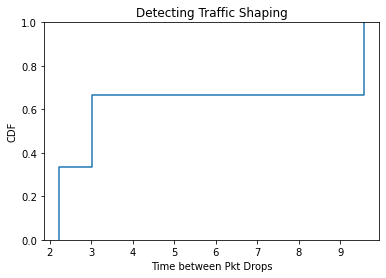

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create the ECDF plot
sns.ecdfplot(data=g_pd, x='lag_drop')

# Customize the plot (optional)
plt.title('Detecting Traffic Shaping')
plt.xlabel('Time between Pkt Drops')
plt.ylabel('CDF')

# Show the plot
plt.show()

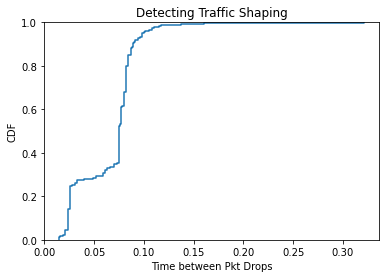

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create the ECDF plot
sns.ecdfplot(data=g_pd, x='lag_drop')

# Customize the plot (optional)
plt.title('Detecting Traffic Shaping')
plt.xlabel('Time between Pkt Drops')
plt.ylabel('CDF')

# Show the plot
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create the ECDF plot
sns.ecdfplot(data=g_pd, x='lag_drop')

# Customize the plot (optional)
plt.title('Detecting Traffic Shaping')
plt.xlabel('Time between Pkt Drops')
plt.ylabel('CDF')

# Show the plot
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create the ECDF plot
sns.ecdfplot(data=g_pd, x='lag_drop')

# Customize the plot (optional)
plt.title('Detecting Traffic Shaping')
plt.xlabel('Time between Pkt Drops')
plt.ylabel('CDF')

# Show the plot
plt.show()

In [54]:
data_pkts.count()

12738

In [41]:
data_pkts.filter(col('tcp_retransmission').isNotNull()).count()

456

In [29]:
flow_df.groupBy('src_ip', 'src_port', 'dst_ip', 'dst_port', 'tcp_seq_raw').count().sort('count', ascending=False).show()

+--------------+--------+--------------+--------+-----------+-----+
|        src_ip|src_port|        dst_ip|dst_port|tcp_seq_raw|count|
+--------------+--------+--------------+--------+-----------+-----+
|192.168.99.210|   55122| 128.111.5.234|    5201| 2951570788| 8270|
| 128.111.5.234|    5201|192.168.99.210|   55122| 2575315899|    2|
|192.168.99.210|   55122| 128.111.5.234|    5201| 2951570751|    2|
| 128.111.5.234|    5201|192.168.99.210|   55122| 2575606683|    1|
| 128.111.5.234|    5201|192.168.99.210|   55122| 2575651419|    1|
| 128.111.5.234|    5201|192.168.99.210|   55122| 2576263743|    1|
| 128.111.5.234|    5201|192.168.99.210|   55122| 2576315469|    1|
| 128.111.5.234|    5201|192.168.99.210|   55122| 2576592273|    1|
| 128.111.5.234|    5201|192.168.99.210|   55122| 2576634213|    1|
| 128.111.5.234|    5201|192.168.99.210|   55122| 2577091359|    1|
| 128.111.5.234|    5201|192.168.99.210|   55122| 2577233955|    1|
| 128.111.5.234|    5201|192.168.99.210|   55122

In [23]:
retransmissions = flow_df.filter(col('tcp_retransmission').isNotNull())

In [25]:
print(retransmissions.count())
retransmissions.select('tcp_seq_raw').show()

456
+-----------+
|tcp_seq_raw|
+-----------+
| 2575322889|
| 2575514415|
| 2575559151|
| 2575637439|
| 2575657011|
| 2575694757|
| 2575731105|
| 2575768851|
| 2575805199|
| 2575840149|
| 2575875099|
| 2575908651|
| 2575960377|
| 2576010705|
| 2576059635|
| 2576112759|
| 2576147709|
| 2576195241|
| 2576256753|
| 2576269335|
+-----------+
only showing top 20 rows



In [26]:
data_pkts = flow_df.filter(col('tcp_retransmission').isNull())

In [ ]:
data_pkts 

In [22]:
flow_df.count()

21012

In [20]:
df.groupBy('tcp_retransmission').count().show()

+------------------+-----+
|tcp_retransmission|count|
+------------------+-----+
|              NULL|20585|
|                 1|  456|
+------------------+-----+



#### Both the port numbers and the udp packet length are all treated as strings when we would like them as ints, specifically a LongType.

#### Should have a schema matching something like this
```
root
 |-- pkt_timestamp: double (nullable = true)
 |-- src_ip: string (nullable = true)
 |-- src_port: long (nullable = true)
 |-- dst_ip: string (nullable = true)
 |-- dst_port: long (nullable = true)
 |-- udp_len: long (nullable = true)
 |-- rtp_seq_num: integer (nullable = true)
 |-- rtp_timestamp: long (nullable = true)
 |-- rtp_ssrc_id: string (nullable = true)
 ```

#### Filter packets between the two participants in the conference call, make sure to filter on both the IP address and port of all participants.

In [10]:
flow_df = df.filter(((col('src_ip') == '192.168.0.203') & \
                     (col('src_port') == 63346) & \
                     (col('dst_ip') == '107.223.12.141') & \
                     (col('dst_port') == 36513)) | \
                    ((col('src_ip') == '107.223.12.141') & \
                     (col('src_port') == 36513) & \
                     (col('dst_ip') == '192.168.0.203') & \
                     (col('dst_port') == 63346)))

#### If we decode the UDP packets as RTP, we observe that there are other packets multiplexed over the same flow, such as RTCP or STUN.   
#### These packets are not RTP protocol and are not used for the methods we are using to infer QoE
#### If a packet is not RTP then wireshark will fail to extract RTP headers from this packet and we will observe NULL values in our dataframe
#### Filter out all packets with a NULL value for the RTP sequence number, RTP timestamp, or RTP ssrc ID

In [11]:
rtp_df = flow_df.filter(col('rtp_seq_num').isNotNull() & \
                        col('rtp_timestamp').isNotNull() & \
                        col('rtp_ssrc_id').isNotNull())

## Identifying Streams

#### We can identify RTP streams based on a combination of (Source IP, Source Port, Destination IP, Destination Port, SSRC id)

#### 4. Why does each RTP stream need to have its own unique SSRC id?   

#### 5. How many different RTP streams are present in this packet capture? How many in each direction?

#### 6. Can you identify the media type for each RTP stream? How bulletproof is the methodology?

In [14]:
ssrc_flow_fields = ['src_ip', 'src_port', 'dst_ip', 'dst_port', 'rtp_ssrc_id']
rtp_streams = rtp_df.select(*ssrc_flow_fields).distinct().show()

+--------------+--------+--------------+--------+-----------+
|        src_ip|src_port|        dst_ip|dst_port|rtp_ssrc_id|
+--------------+--------+--------------+--------+-----------+
| 192.168.0.203|   63346|107.223.12.141|   36513| 0x989254a4|
|107.223.12.141|   36513| 192.168.0.203|   63346| 0x55934d58|
| 192.168.0.203|   63346|107.223.12.141|   36513| 0xd92d7a3b|
|107.223.12.141|   36513| 192.168.0.203|   63346| 0x06ec3145|
+--------------+--------+--------------+--------+-----------+



In [15]:
# %load ./review2-code.txt
ssrc_flow_fields = ['src_ip', 'src_port', 'dst_ip', 'dst_port', 'rtp_ssrc_id']
rtp_streams = rtp_df.groupBy(*ssrc_flow_fields)\
                    .agg(F.count('*').alias('num_pkts'),
                         F.sum('udp_len').alias('total_bytes'))

rtp_streams.sort('src_ip').show(truncate=False)

+--------------+--------+--------------+--------+-----------+--------+-----------+
|src_ip        |src_port|dst_ip        |dst_port|rtp_ssrc_id|num_pkts|total_bytes|
+--------------+--------+--------------+--------+-----------+--------+-----------+
|107.223.12.141|36513   |192.168.0.203 |63346   |0x55934d58 |6655    |7176410    |
|107.223.12.141|36513   |192.168.0.203 |63346   |0x06ec3145 |1390    |197447     |
|192.168.0.203 |63346   |107.223.12.141|36513   |0x989254a4 |32690   |37632831   |
|192.168.0.203 |63346   |107.223.12.141|36513   |0xd92d7a3b |3663    |310431     |
+--------------+--------+--------------+--------+-----------+--------+-----------+



In [ ]:
# %load ./review2-answers.txt
4. Why does each RTP stream need to have its own unique SSRC id?   
    - All streams are sent over the same UDP flow, audio and video packets needs to be distinguished so they can be reassembled separately
5. How many different RTP streams are present in this packet capture? How many in each direction?
    - 4 RTP streams, 2 in each direction
6. Can you identify the media type for each RTP stream? How bulletproof is the methodology?
    - 0x55934d58 and 0x989254a4 are video
    - 0x06ec3145 and 0xd92d7a3b are audio
    - Using the total bytes sent over the stream. This works in this situation but can be faulty when we compare streams of different durations for different services that may use different encodings, causing the total bytes sent over the RTP stream to be too coarse grained a metric

## Audio / Video Frames

Real-time content groups data into frames that are re-assembled at the end user and rendered.  
Each frame will represent a very short amount of time (less than a second), however in video streaming we grouped data into chunks representing multiple seconds of video.  
To group packets into frames we will utilize the RTP timestamp in the RTP headers.  
From Section 5.1 in [RFC 3550](https://datatracker.ietf.org/doc/html/rfc3550#section-5.1) we know that **several consecutive RTP packets will have equal timestamps if they are (logically) generated at once, e.g., belong to the same video frame.**

#### 7. How many frames are sent by each RTP stream?

In [18]:
# %load ./review3-code.txt
frame_fields = ['src_ip', 'src_port', 'dst_ip', 'dst_port', 'rtp_ssrc_id', 'rtp_timestamp']
ssrc_flow_fields = ['src_ip', 'src_port', 'dst_ip', 'dst_port', 'rtp_ssrc_id']
frames_per_stream = rtp_df.select(*frame_fields)\
                    .distinct() \
                    .groupBy(*ssrc_flow_fields) \
                    .agg(F.count('*').alias('num_frames'))

frames_per_stream.sort('src_ip').show(truncate=False)

+--------------+--------+--------------+--------+-----------+----------+
|src_ip        |src_port|dst_ip        |dst_port|rtp_ssrc_id|num_frames|
+--------------+--------+--------------+--------+-----------+----------+
|107.223.12.141|36513   |192.168.0.203 |63346   |0x55934d58 |1857      |
|107.223.12.141|36513   |192.168.0.203 |63346   |0x06ec3145 |1390      |
|192.168.0.203 |63346   |107.223.12.141|36513   |0x989254a4 |3718      |
|192.168.0.203 |63346   |107.223.12.141|36513   |0xd92d7a3b |3662      |
+--------------+--------+--------------+--------+-----------+----------+



In [ ]:
%load ./review3-answers.txt

## Inferring Frame Size

#### The size of the frames in each stream can be used to infer whether the media type is audio or video.

#### 8. Plot a time series of all audio RTP stream frame sizes for each frame.

#### 9. Plot a time series of all video RTP stream frame sizes for each frame.

In [19]:
frame_fields = ['src_ip', 'src_port', 'dst_ip', 'dst_port', 'rtp_ssrc_id', 'rtp_timestamp']

frames_df = rtp_df.groupBy(*frame_fields)\
                     .agg(F.min('pkt_timestamp').alias('frame_start_time'),
                          F.max('pkt_timestamp').alias('frame_end_time'),
                          F.count('*').alias('frame_pkt_count'),
                          F.sum(col('udp_len')).alias('frame_size'))
                     
frame_window = Window.partitionBy(*ssrc_flow_fields).orderBy('rtp_timestamp')
frames_df = frames_df.withColumn('frame_num', F.row_number().over(frame_window))

frames_pd = frames_df.select('frame_num', 'frame_size', 'rtp_ssrc_id')\
                      .sort('frame_num')\
                      .toPandas()

In [20]:
audio_ssrc_ids = ['0x06ec3145', '0xd92d7a3b']
video_ssrc_ids = ['0x55934d58', '0x989254a4']

audio_frames_df = frames_df.filter(col('rtp_ssrc_id').isin(audio_ssrc_ids))
video_frames_df = frames_df.filter(col('rtp_ssrc_id').isin(video_ssrc_ids))

In [21]:
audio_pd = audio_frames_df.select('frame_end_time', 'frame_size', 'rtp_ssrc_id')\
                          .sort('frame_end_time')\
                          .toPandas()
video_pd = video_frames_df.select('frame_end_time', 'frame_size', 'rtp_ssrc_id')\
                          .sort('frame_end_time')\
                          .toPandas()

In [ ]:
# %load ./graph-frame-sizes-code.txt
import matplotlib.pyplot as mpl

mpl.figure(figsize=(10, 6))

for ssrc in sorted(frames_pd['rtp_ssrc_id'].unique()):
    series = frames_pd[frames_pd['rtp_ssrc_id'] == ssrc]
    mpl.plot(series['frame_num'], series['frame_size'], label=ssrc)

mpl.xlabel('Frame Number')
mpl.ylabel('Frame Size (bytes)')
mpl.legend()

mpl.show()

In [ ]:
# %load ./graph-audio-frame-sizes-code.txt
import matplotlib.pyplot as mpl

mpl.figure(figsize=(10, 6))

for ssrc in sorted(audio_pd['rtp_ssrc_id'].unique()):
    series = audio_pd[audio_pd['rtp_ssrc_id'] == ssrc]
    mpl.plot(series['frame_end_time'], series['frame_size'], label=ssrc)

mpl.xlabel('Frame Arrival Time')
mpl.ylabel('Frame Size (bytes)')
mpl.legend()

mpl.show()

In [ ]:
# %load ./graph-video-frame-sizes-code.txt
import matplotlib.pyplot as mpl

mpl.figure(figsize=(10, 6))

for ssrc in sorted(video_pd['rtp_ssrc_id'].unique()):
    series = video_pd[video_pd['rtp_ssrc_id'] == ssrc]
    mpl.plot(series['frame_end_time'], series['frame_size'], label=ssrc)

mpl.xlabel('Frame Arrival Time')
mpl.ylabel('Frame Size (bytes)')
mpl.legend()

mpl.show()

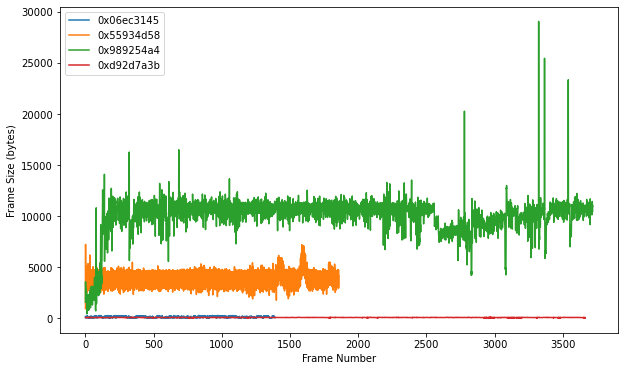

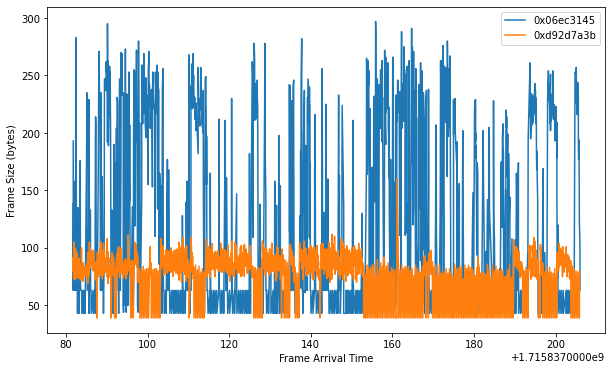

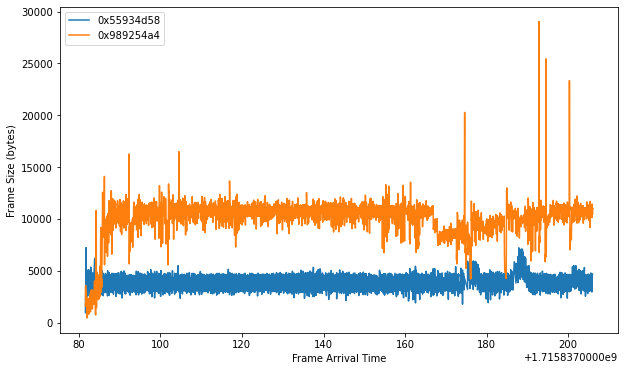

## Inferring FPS

#### Each RTP stream will try to maintain a certain fps which will determine the smoothness of the video content.  
#### We can infer the FPS of the stream after the delivery of each frame, by counting the number of frames that finished delivering in the past second, further described in this [paper](https://dl.acm.org/doi/abs/10.1145/3517745.3561414). 

#### 10. Plot a time series of the FPS after the delivery of each frame for all video RTP streams.
Hint: If you are using pyspark the [Window.rangeBetween()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.Window.rangeBetween.html) function is very useful for this calculation

In [ ]:
# %load ./graph-fps-code.txt
fps_window = Window.partitionBy(*ssrc_flow_fields).orderBy("frame_end_time").rangeBetween(-1, 0)
video_frames_df = video_frames_df.withColumn("fps", F.size(F.collect_set('frame_num').over(fps_window)))

fps_pd = video_frames_df.select('frame_num', 'frame_end_time', 'fps', 'rtp_ssrc_id')\
                      .sort('frame_num')\
                      .toPandas()

import matplotlib.pyplot as mpl

mpl.figure(figsize=(10, 6))

for ssrc in sorted(fps_pd['rtp_ssrc_id'].unique()):
    series = fps_pd[fps_pd['rtp_ssrc_id'] == ssrc]
    mpl.plot(series['frame_end_time'], series['fps'], label=ssrc)

mpl.xlabel('Frame Number')
mpl.ylabel('FPS')
mpl.legend()

mpl.show()

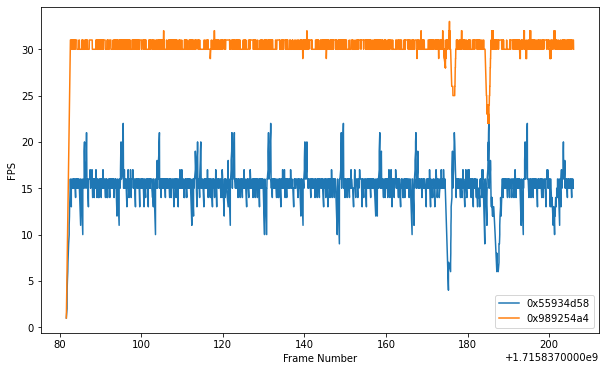

## Infer Video Sampling Rate

#### Sampling rate (in Hz) is the rate at which the timestamp increases over 1 second of wallclock time.
#### For example, if video is being streamed at 90kHz then we would see the RTP timestamp increase by 90k between two frames that should be played exactly 1 second apart.  
#### Using this fact, we can infer the sampling rate that is likely used by the RTP stream. Most common sampling rates are 8kHz, 16kHz, 48kHz, 90kHz.  
#### Look at the RTP timestamp difference between the last frame and first frame in each 1 second window that we used in the fps calculation (Window.rangeBetween())  

#### 11. What are the sampling rates used by the audio RTP streams in this capture?  
#### 12. What are the sampling rates used by the video RTP streams in this capture?  

In [ ]:
%load ./review5-answers.txt

In [22]:
# %load ./review5-audio-code.txt
fps_window = Window.partitionBy(*ssrc_flow_fields).orderBy("frame_end_time").rangeBetween(-1, 0)
audio_frames_df = audio_frames_df.withColumn("fps_min_rtp_timestamp", F.min('rtp_timestamp').over(fps_window))
audio_frames_df = audio_frames_df.withColumn("fps_max_rtp_timestamp", F.max('rtp_timestamp').over(fps_window))
audio_frames_df = audio_frames_df.withColumn("fps_delta_rtp_timestamp", col('fps_max_rtp_timestamp') - col('fps_min_rtp_timestamp'))

audio_sampling_rates = audio_frames_df.groupBy(*ssrc_flow_fields)\
                                      .agg((F.percentile_approx('fps_delta_rtp_timestamp', 0.5).cast(DoubleType())).alias('sampling_rate'),
                                           (F.avg('fps_delta_rtp_timestamp').cast(DoubleType())).alias('avg_sampling_rate'))

audio_sampling_rates.show(truncate=False)

+--------------+--------+--------------+--------+-----------+-------------+-----------------+
|src_ip        |src_port|dst_ip        |dst_port|rtp_ssrc_id|sampling_rate|avg_sampling_rate|
+--------------+--------+--------------+--------+-----------+-------------+-----------------+
|107.223.12.141|36513   |192.168.0.203 |63346   |0x06ec3145 |46080.0      |43235.22302158274|
|192.168.0.203 |63346   |107.223.12.141|36513   |0xd92d7a3b |47040.0      |45616.51556526488|
+--------------+--------+--------------+--------+-----------+-------------+-----------------+



In [23]:
# %load ./review5-video-code.txt
fps_window = Window.partitionBy(*ssrc_flow_fields).orderBy("frame_end_time").rangeBetween(-1, 0)
video_frames_df = video_frames_df.withColumn("fps_min_rtp_timestamp", F.min('rtp_timestamp').over(fps_window))
video_frames_df = video_frames_df.withColumn("fps_max_rtp_timestamp", F.max('rtp_timestamp').over(fps_window))
video_frames_df = video_frames_df.withColumn("fps_delta_rtp_timestamp", col('fps_max_rtp_timestamp') - col('fps_min_rtp_timestamp'))

video_sampling_rates = video_frames_df.groupBy(*ssrc_flow_fields)\
                                      .agg((F.percentile_approx('fps_delta_rtp_timestamp', 0.5).cast(DoubleType())).alias('sampling_rate'))

video_sampling_rates.show(truncate=False)

+--------------+--------+--------------+--------+-----------+-------------+
|src_ip        |src_port|dst_ip        |dst_port|rtp_ssrc_id|sampling_rate|
+--------------+--------+--------------+--------+-----------+-------------+
|107.223.12.141|36513   |192.168.0.203 |63346   |0x55934d58 |85770.0      |
|192.168.0.203 |63346   |107.223.12.141|36513   |0x989254a4 |87030.0      |
+--------------+--------+--------------+--------+-----------+-------------+



## Calculating Frame-level Jitter 

#### Using the sampling rates, we can infer the jitter for each RTP stream, which is measuring the variance in the delivery of frames. 
#### The applications will maintain a jitter buffer based on the current estimate of jitter to avoid stuttering / freeze frames.
#### The calculation for jitter can be taken from the Appendix A.8 of [RFC 3550](https://datatracker.ietf.org/doc/html/rfc3550#appendix-A.8)

```
The inputs are r->ts, the timestamp from
the incoming packet, and arrival, the current time in the same units.
Here s points to state for the source; s->transit holds the relative
transit time for the previous packet, and s->jitter holds the
estimated jitter.  The jitter field of the reception report is
measured in timestamp units and expressed as an unsigned integer, but
the jitter estimate is kept in a floating point.  As each data packet
arrives, the jitter estimate is updated:

  int transit = arrival - r->ts;
  int d = transit - s->transit;
  s->transit = transit;
  if (d < 0) d = -d;
  s->jitter += (1./16.) * ((double)d - s->jitter);

```
Both `s->transit` and `s->jitter` can be initialized to 0.

#### 13. Plot the frame-level jitter for audio packets

#### 14. Plot the frame-level jitter for video packets

For pyspark, you will need to define an RDD function that iteratively computes an estimate, since the jitter estimate after the arrival of a frame is dependent on the arrivals of all the frames before it.

In [ ]:
# %load ./graph-audio-jitter-code.txt
audio_frames_df = audio_frames_df.withColumn('sampling_rate_hz', F.lit(48000.0).cast(DoubleType()))
audio_frame_jitter = audio_frames_df.withColumn('transit_time', col('frame_end_time') - ((1.0/(col('sampling_rate_hz')*1.0)) * col('rtp_timestamp'))) \
                                    .withColumn('prev_transit_time', F.lag(col('transit_time'), 1).over(frame_window)) \
                                    .withColumn('delta_transit_time', F.abs(col('transit_time') - col('prev_transit_time')))
    
def calculate_estimated_jitter(iterator):
    estimated_jitter = None
    init_jitter = None
    for row in iterator:
        try:
            if (row.delta_transit_time is None):
                continue
            elif (init_jitter is None):
                init_jitter = 0.0625 * row.delta_transit_time
                yield row.src_ip, row.src_port, row.dst_ip, row.dst_port, row.rtp_ssrc_id, row.rtp_timestamp, row.frame_end_time, row.frame_num, None
            elif (estimated_jitter is None):
                estimated_jitter = 0.0625 * (row.delta_transit_time - init_jitter)
                yield row.src_ip, row.src_port, row.dst_ip, row.dst_port, row.rtp_ssrc_id, row.rtp_timestamp, row.frame_end_time, row.frame_num, estimated_jitter
            else:
                estimated_jitter += 0.0625 * (row.delta_transit_time - estimated_jitter)
                yield row.src_ip, row.src_port, row.dst_ip, row.dst_port, row.rtp_ssrc_id, row.rtp_timestamp, row.frame_end_time, row.frame_num, estimated_jitter
        except:
            yield row.src_ip, row.src_port, row.dst_ip, row.dst_port, row.rtp_ssrc_id, row.rtp_timestamp, row.frame_end_time, row.frame_num, None

audio_frame_jitter = audio_frame_jitter.repartition(*ssrc_flow_fields).orderBy("rtp_timestamp").rdd.mapPartitions(calculate_estimated_jitter) \
                        .toDF(["src_ip",
                               "src_port",
                               "dst_ip",
                               "dst_port",
                               "rtp_ssrc_id",
                               "rtp_timestamp",
                               "frame_end_time",
                               "frame_num",
                               "jitter"])


audio_jitter_pd = audio_frame_jitter.select('frame_num', 'frame_end_time', 'jitter', 'rtp_ssrc_id')\
                      .sort('frame_num')\
                      .toPandas()

import matplotlib.pyplot as mpl

mpl.figure(figsize=(10, 6))

for ssrc in sorted(audio_jitter_pd['rtp_ssrc_id'].unique()):
    series = audio_jitter_pd[audio_jitter_pd['rtp_ssrc_id'] == ssrc]
    mpl.plot(series['frame_end_time'], series['jitter'], label=ssrc)

mpl.xlabel('Frame Arrival Time')
mpl.ylabel('Jitter (s)')
mpl.legend()

mpl.show()

In [ ]:
# %load ./graph-video-jitter-code.txt
video_frames_df = video_frames_df.withColumn('sampling_rate_hz', F.lit(90000.0).cast(DoubleType()))
video_frame_jitter = video_frames_df.withColumn('transit_time', col('frame_end_time') - ((1.0/(col('sampling_rate_hz')*1.0)) * col('rtp_timestamp'))) \
                                    .withColumn('prev_transit_time', F.lag(col('transit_time'), 1).over(frame_window)) \
                                    .withColumn('delta_transit_time', F.abs(col('transit_time') - col('prev_transit_time')))

def calculate_estimated_jitter(iterator):
    estimated_jitter = None
    init_jitter = None
    for row in iterator:
        try:
            if (row.delta_transit_time is None):
                continue
            elif (init_jitter is None):
                init_jitter = 0.0625 * row.delta_transit_time
                yield row.src_ip, row.src_port, row.dst_ip, row.dst_port, row.rtp_ssrc_id, row.rtp_timestamp, row.frame_end_time, row.frame_num, None
            elif (estimated_jitter is None):
                estimated_jitter = 0.0625 * (row.delta_transit_time - init_jitter)
                yield row.src_ip, row.src_port, row.dst_ip, row.dst_port, row.rtp_ssrc_id, row.rtp_timestamp, row.frame_end_time, row.frame_num, estimated_jitter
            else:
                estimated_jitter += 0.0625 * (row.delta_transit_time - estimated_jitter)
                yield row.src_ip, row.src_port, row.dst_ip, row.dst_port, row.rtp_ssrc_id, row.rtp_timestamp, row.frame_end_time, row.frame_num, estimated_jitter
        except:
            yield row.src_ip, row.src_port, row.dst_ip, row.dst_port, row.rtp_ssrc_id, row.rtp_timestamp, row.frame_end_time, row.frame_num, None

video_frame_jitter = video_frame_jitter.repartition(*ssrc_flow_fields).orderBy("rtp_timestamp").rdd.mapPartitions(calculate_estimated_jitter) \
                        .toDF(["src_ip",
                               "src_port",
                               "dst_ip",
                               "dst_port",
                               "rtp_ssrc_id",
                               "rtp_timestamp",
                               "frame_end_time",
                               "frame_num",
                               "jitter"])

video_jitter_pd = video_frame_jitter.select('frame_num', 'frame_end_time', 'jitter', 'rtp_ssrc_id')\
                      .sort('frame_num')\
                      .toPandas()

import matplotlib.pyplot as mpl

mpl.figure(figsize=(10, 6))

for ssrc in sorted(video_jitter_pd['rtp_ssrc_id'].unique()):
    series = video_jitter_pd[video_jitter_pd['rtp_ssrc_id'] == ssrc]
    mpl.plot(series['frame_end_time'], series['jitter'], label=ssrc)

mpl.xlabel('Frame Arrival Time')
mpl.ylabel('Jitter (s)')
mpl.legend()

mpl.show()

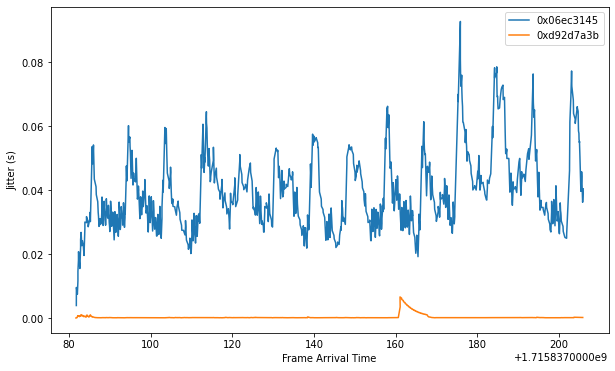

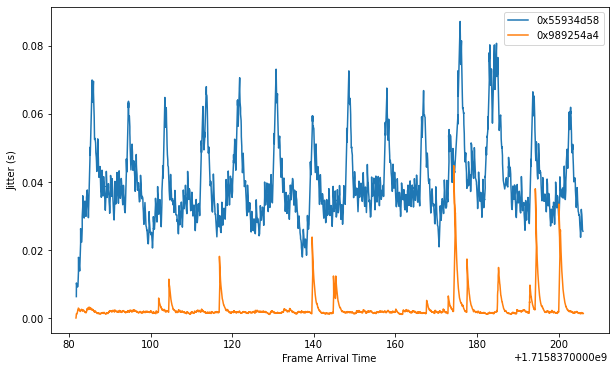